In [103]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import recall_score, accuracy_score

from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

data = pd.read_csv('./train2.csv')
data.tail()

,sex,age,WBC,RBC,BAS#,HGB,HCT,MCV,MCH,MCHC,...,BAS%,ALY,ALY%,LIC,LIC%,IG#,IG%,NRBC#,NRBC%,P-LCR
8753,1.0,31,10.8,5.84,0.1,176,54.3,93,30.1,324,...,0.5,NaN,NaN,NaN,NaN,0.04,0.4,0.0,0.0,20.2
8754,1.0,36,7.1,5.55,0.1,173,52.3,94.2,31.2,331,...,0.8,NaN,NaN,NaN,NaN,0.05,0.7,0.0,0.0,12.8
8755,1.0,25,6.9,5.58,0,164,50.7,90.9,29.4,323,...,0.6,NaN,NaN,NaN,NaN,0.01,0.1,0.0,0.0,18.1
8756,2.0,25,7.6,6.01,0,127,43.5,72.4,21.1,292,...,0.5,NaN,NaN,NaN,NaN,0.02,0.3,0.0,0.0,NaN
8757,1.0,23,5.3,5.72,0,168,51.0,89.2,29.4,329,...,0.6,NaN,NaN,NaN,NaN,0.01,0.2,0.0,0.0,16.2


In [104]:
data = data.replace(to_replace='?', value=np.nan)
data = data.apply(lambda x: pd.to_numeric(x, errors='coerce'))
data.dtypes

sex       float64
age       float64
WBC       float64
RBC       float64
BAS#      float64
HGB         int64
HCT       float64
MCV       float64
MCH       float64
MCHC      float64
RDW-CV    float64
PLT       float64
MPV       float64
PCT       float64
PDW       float64
LYM#      float64
LYM%      float64
MONO      float64
MONO%     float64
NEU#      float64
NEU%      float64
EOS#      float64
EOS%      float64
BAS       float64
BAS%      float64
ALY       float64
ALY%      float64
LIC       float64
LIC%      float64
IG#       float64
IG%       float64
NRBC#     float64
NRBC%     float64
P-LCR     float64
dtype: object

In [117]:
# 丢弃某些列数据完全缺失的情况
data.dropna(axis=0, how='any', subset=['sex'], inplace=True)
data.dropna(axis=1, how='all', inplace=True)
data.reset_index(drop=True, inplace=True)
data.sex = data.sex.astype(int)
data.sex = data.sex.apply(lambda x: x-1)

In [118]:
def num_missing(x):
    return sum(x.isnull())

In [119]:
# axis=0, 表示对每一列运用 num_missing; axis=1, 表示对每一行运用;
data.apply(num_missing, axis=0)

sex          0
age         21
WBC          0
RBC          0
BAS#         2
HGB          0
HCT          0
MCV          1
MCH          1
MCHC         1
RDW-CV       1
PLT          1
MPV        283
PCT        284
PDW        284
LYM#         3
LYM%         3
MONO      1976
MONO%     1976
NEU#         2
NEU%         2
EOS#         2
EOS%         2
BAS%         2
IG#       1976
IG%       1976
NRBC#     1976
NRBC%     1976
P-LCR     1475
dtype: int64

In [120]:

# One has to be mindful that in python (and numpy), the nan's don’t compare equal, but None's do. Note that Pandas/numpy uses the fact that np.nan != np.nan, and treats None like np.nan.
print None == None
print np.nan == np.nan
# data.notnull()
# data.isnull()
#缺失值填充
# data.fillna(method='ffill')
# data.fillna(method='bfill')

# mean1 = data['IG#'].mean()
# mean2 = data['IG%'].mean()
# data.fillna({'IG#':mean1, 'IG%':mean2})

True
False


In [121]:
dataset = data.where(pd.notnull(data), data.mean(), axis='columns')
dataset.head()

,sex,age,WBC,RBC,BAS#,HGB,HCT,MCV,MCH,MCHC,...,NEU#,NEU%,EOS#,EOS%,BAS%,IG#,IG%,NRBC#,NRBC%,P-LCR
0,0,85.0,6.4,4.32,0.0,134,43.0,99.4,31.1,313.0,...,4.3,67.4,0.2,2.6,0.2,0.064197,0.622843,0.002913,0.031647,24.821409
1,0,89.0,8.5,3.87,0.1,128,39.2,101.3,33.1,327.0,...,4.4,51.7,0.4,4.7,0.7,0.010000,0.100000,0.000000,0.000000,27.500000
2,0,87.0,7.5,4.00,0.0,128,38.4,96.0,32.0,333.0,...,5.1,67.7,0.3,3.3,0.4,0.030000,0.400000,0.000000,0.000000,36.800000
3,0,75.0,7.8,2.28,0.1,65,19.4,85.4,28.6,335.0,...,6.9,87.9,0.0,0.3,0.9,0.064197,0.622843,0.002913,0.031647,24.821409
4,1,84.0,4.8,5.21,0.0,117,39.4,75.6,22.5,297.0,...,2.6,53.3,0.1,1.5,0.6,0.010000,0.200000,0.000000,0.000000,29.000000


In [122]:
def sex_preprocess(data):
    #不影响原来的数据表格
    df = data.copy()
    # 去掉有缺失维度的数据
    df = df.replace(to_replace='?', value=np.nan)
    df = df.dropna(how='any')
    #pd.get_dummies(data_set)  # one-hot 但是会增加列数, 计算会变慢, 特别是类别很多的时候
    # data_set['sex'] = data_set['sex'].apply(lambda x: 1 if x == '男' else 0)
    # df['sex'] = df['sex'].map({'男': 1, '女': 0}).astype(int)
    selected_names = [name for name in df.columns if name != 'id' and name != 'sex' and name != 'age']
    X_data = df[selected_names].as_matrix()
    y_data = df['sex'].as_matrix()
    # SVM 一般要对数据做归一化处理
    #X_data = preprocessing.scale(X_data)
    return X_data, y_data

In [123]:
X_data, y_data = sex_preprocess(dataset)
X_data = preprocessing.scale(X_data)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.20, random_state=0)

In [124]:
def evaluate(clf, X_test, y_test):
    y_hat = clf.predict(X_test)
    correct_pairs = [(x,y) for (x,y) in zip(y_test, y_hat) if x == y]
    accuracy = float(len(correct_pairs)) / len(y_hat)
    return accuracy

Logistic Regression             测试集acc/recall:  0.797945205479/ 0.795340198429 训练集acc/recall:   0.79414703783/  0.79414703783
Linear SVM                      测试集acc/recall:  0.799086757991/ 0.795606651933 训练集acc/recall:  0.799571734475/ 0.799571734475
RBF SVM                         测试集acc/recall:  0.823630136986/ 0.821276312284 训练集acc/recall:  0.862241256246/ 0.862241256246
Decision Tree                   测试集acc/recall:  0.780821917808/   0.7748311155 训练集acc/recall:  0.810278372591/ 0.810278372591
Random Forest                   测试集acc/recall:  0.767123287671/ 0.759619755176 训练集acc/recall:  0.805424696645/ 0.805424696645
AdaBoost                        测试集acc/recall:  0.809360730594/ 0.805739721948 训练集acc/recall:  0.827123483226/ 0.827123483226
Gradient Boosting Decision Tree 测试集acc/recall:  0.823630136986/ 0.820672873466 训练集acc/recall:  0.890506780871/ 0.890506780871
XGBoost                         测试集acc/recall:  0.816210045662/ 0.812933966552 训练集acc/recall:  0.863954318344/ 0.86395

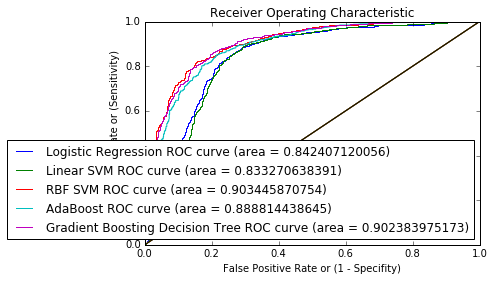

In [128]:
names = ["Logistic Regression", "Linear SVM", "RBF SVM", 
         "Decision Tree", "Random Forest", "AdaBoost", "Gradient Boosting Decision Tree", "XGBoost"]
classifiers = [
    LogisticRegression(C=10),
    svm.SVC(kernel="linear", C=0.025),
    svm.SVC(gamma=0.01, C=10),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, min_samples_leaf=9),
    XGBClassifier()]

for name, clf in zip(names,classifiers):
    clf.fit(X_train, y_train)
    print "{:31} 测试集acc/recall: {:15}/{:15} 训练集acc/recall: {:15}/{:15}".format(name, 
        accuracy_score(y_test, clf.predict(X_test)), recall_score(y_test, clf.predict(X_test), average='macro'), 
        accuracy_score(y_train, clf.predict(X_train)), recall_score(y_train, clf.predict(X_train), average='micro'))
    
for name, clf in zip(names, classifiers):
    try: 
        importances = clf.feature_importances_
        indices = np.argsort(importances)[::-1]
        print '{}特征权值分布为: '.format(name)
        for f in range(X_train.shape[1]):
            print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    except AttributeError:
        print '{} has no feture_importances_'.format(name)
    
# b: blue
# g: green
# r: red
# c: cyan
# m: magenta
# y: yellow
# k: black
# w: white
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
for name, clf, color in zip(names,classifiers, colors):
    # y_score = classifier.fit(X_train, y_train).decision_function(X_test)
    try:
        y_score = clf.decision_function(X_test)
    except AttributeError:
        print '{} has no decision_function'.format(name)
        continue

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_test, y_score, sample_weight=None)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='{} ROC curve (area = {})'.format(name, roc_auc))
    plt.plot([0, 1], [0, 1], color)  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

In [140]:
def feature_select(clf, X_train, y_train, X_test):
    # 预训练
    clf.fit(X_train, y_train)
    
    # 评估特征
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    print("特征权值分布为: ")
    for f in range(X_train.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
    # 过滤掉权值小于threshold的特征
    model = SelectFromModel(clf, threshold=0.03, prefit=True)
    X_train_new = model.transform(X_train)
    X_test_new = model.transform(X_test)
    print '训练集和测试集的容量以及选择的特征数为: ', X_train_new.shape, X_test_new.shape
    # 返回压缩特征之后的训练集和测试集
    return X_train_new, X_test_new

In [147]:
index = 7
X_train_compressed, X_test_compressed = feature_select(classifiers[index], X_train, y_train, X_test)

for name, clf in zip(names,classifiers):
    clf.fit(X_train_compressed, y_train)
    
    print "{:31} 测试集acc: {:15} 训练集acc: {:15}".format(name, evaluate(clf, X_test_compressed, y_test), evaluate(clf, X_train_compressed, y_train))
    print "{:31} 测试集recall: {:15} 训练集recall: {:15}".format(name, 
        recall_score(y_test, clf.predict(X_test_compressed)), 
        recall_score(y_train, clf.predict(X_train_compressed)))

特征权值分布为: 
1. feature 1 (0.105339)
2. feature 9 (0.105339)
3. feature 3 (0.086580)
4. feature 4 (0.064935)
5. feature 16 (0.064935)
6. feature 8 (0.059163)
7. feature 14 (0.049062)
8. feature 6 (0.046176)
9. feature 7 (0.046176)
10. feature 13 (0.043290)
11. feature 20 (0.040404)
12. feature 26 (0.037518)
13. feature 19 (0.036075)
14. feature 15 (0.033189)
15. feature 0 (0.031746)
16. feature 22 (0.027417)
17. feature 5 (0.025974)
18. feature 12 (0.020202)
19. feature 18 (0.020202)
20. feature 17 (0.015873)
21. feature 21 (0.010101)
22. feature 23 (0.010101)
23. feature 10 (0.007215)
24. feature 25 (0.005772)
25. feature 11 (0.004329)
26. feature 24 (0.002886)
27. feature 2 (0.000000)
训练集和测试集的容量以及选择的特征数为:  (7005, 15) (1752, 15)
Logistic Regression             测试集acc:  0.791095890411 训练集acc:  0.790435403283
Logistic Regression             测试集recall:  0.856209150327 训练集recall:  0.848051948052
Linear SVM                      测试集acc:  0.800799086758 训练集acc:  0.795860099929
Linear SVM       